 1. Import data and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
stim = np.genfromtxt('MDA1_data/stim.txt')
spikes = np.genfromtxt('MDA1_data/spikes.txt')

In [3]:
spikes.shape

(25, 42600)

In [4]:
spikes[0][:60]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0.])

2. Reshape response data into response matrix

In [41]:
tau = 30
R = np.empty([len(stim)-2*tau, 60*25+1])
for cell in range(25):
    R[:,0]=1
    for t in range(len(stim)-2*tau):
        R[t][60*cell+1:60*cell+61] = spikes[cell][t:t+2*tau]    

In [132]:
t_stop = [2000,4000,8000, 10000,20000,30000]
t_start = [0,0,0,10000,10000,10000]
Rs = []
for i, stop in enumerate(t_stop):
    R_curr = np.empty([stop, 60*25+1])
    for cell in range(25):
        R_curr[:,0]=1
        for t in range(stop):
            R_curr[t][60*cell+1:60*cell+61] = spikes[cell][t_start[i]+t:t_start[i]+t+2*tau]
    Rs.append(R_curr)

3. Find f

In [133]:
fs = []
for i in range(3):    
    f_curr = np.dot(np.linalg.inv(np.dot(np.transpose(Rs[i]),Rs[i])),
                   np.dot(np.transpose(Rs[i]),stim[t_start[i]+tau:t_start[i]+t_stop[i]+tau]))
    fs.append(f_curr)

In [134]:
st_ests = []
rs = []
for i in range(6):
    st_est_curr = np.dot(Rs[i],fs[i%3])
    r_curr, _ = stats.pearsonr(stim[t_start[i]+tau:t_start[i]+t_stop[i]+tau], st_est_curr)
    st_ests.append(st_est_curr)
    rs.append(r_curr)

In [135]:
rs

[0.985586856875865,
 0.9468761524472273,
 0.9291719028939633,
 0.6961444493393634,
 0.8199659360370221,
 0.8647065224435069]

Text(0.5, 0, 'time')

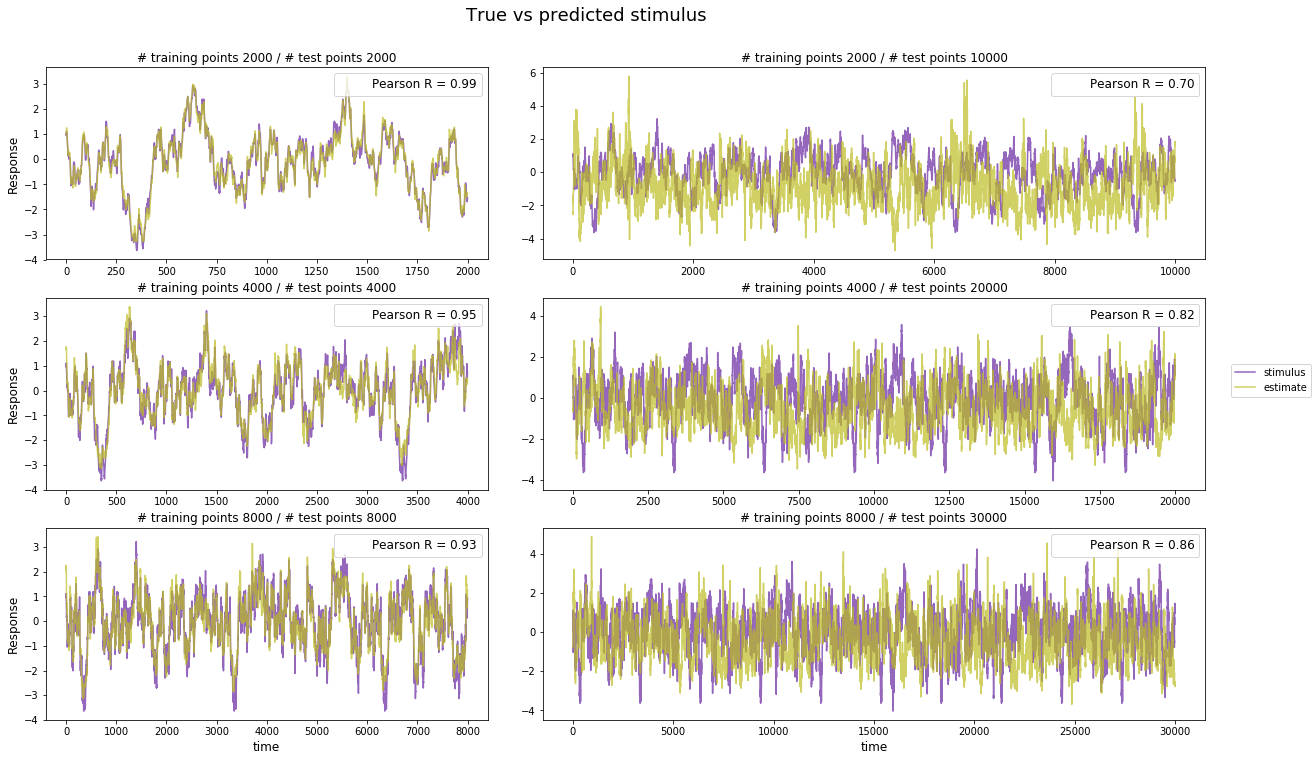

In [175]:
fig, ax = plt.subplots(3, 2, figsize = (20,12), gridspec_kw={'width_ratios': [2,3]})
fig.suptitle('True vs predicted stimulus', fontsize = 18, y = 0.95)
for i in range(3):
    ax[i][0].plot(stim[tau:t_stop[i]+tau], c = 'tab:purple')
    ax[i][0].plot(st_ests[i], alpha = 0.7, c = 'tab:olive')
    ax[i][0].plot([], [], ' ', label="Pearson R = {:.2f}".format(rs[i]))
    
    ax[i][1].plot(stim[tau:t_stop[i+3]+tau], c = 'tab:purple')
    ax[i][1].plot(st_ests[i+3], alpha = 0.7, c = 'tab:olive')
    ax[i][1].plot([], [], ' ', label="Pearson R = {:.2f}".format(rs[i+3]))
    
    ax[i][0].legend(fontsize = 12, loc = 1)
    ax[i][1].legend(fontsize = 12, loc = 1)
    ax[i][0].set_ylabel('Response', fontsize = 12)
    ax[i][0].set_title('# training points {} / # test points {}'.format(t_stop[i], t_stop[i]), fontsize = 12)
    ax[i][1].set_title('# training points {} / # test points {}'.format(t_stop[i], t_stop[i+3]), fontsize = 12)

fig.legend(['stimulus','estimate'],fontsize = 10, loc = 'center right', borderaxespad=0.1)    
plt.subplots_adjust(wspace = 0.1, right = 0.93)
ax[2][0].set_xlabel('time', fontsize = 12)
ax[2][1].set_xlabel('time', fontsize = 12)

In [190]:
cross_est = []
cross_rs = np.empty([3,3])
for i_test in range(3):
    list_est = []
    for j_train in range(3):
        est_curr = np.dot(Rs[j_train+3],fs[i_test])
        curr_stim = stim[t_start[j_train+3]+tau:t_start[j_train+3]+t_stop[j_train+3]+tau]
        cross_rs[i_test][j_train], _ = stats.pearsonr(curr_stim, est_curr)
        list_est.append(est_curr)
    cross_est.append(list_est)

([<matplotlib.axis.XTick at 0x3394bcd68>,
 <a list of 3 Text xticklabel objects>)

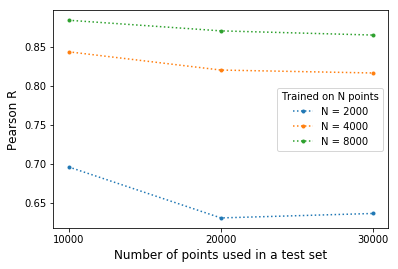

In [209]:
plt.figure(figsize = (6,4))
for i in range(3):
    plt.plot((t_start[3:]+t_stop[3:])[3:], cross_rs[i], 
             label = 'N = {}'.format(t_stop[i]), ls = ':', marker = '.')
plt.legend(title = 'Trained on N points')
plt.xlabel('Number of points used in a test set', fontsize = 12)
plt.ylabel('Pearson R', fontsize = 12)
plt.xticks(range(10000,40000,10000))

In [192]:
cross_rs

array([[0.69614445, 0.63100268, 0.63668442],
       [0.84330818, 0.81996594, 0.81623255],
       [0.88363546, 0.87005812, 0.86470652]])

Text(0.5, 0, 'time')

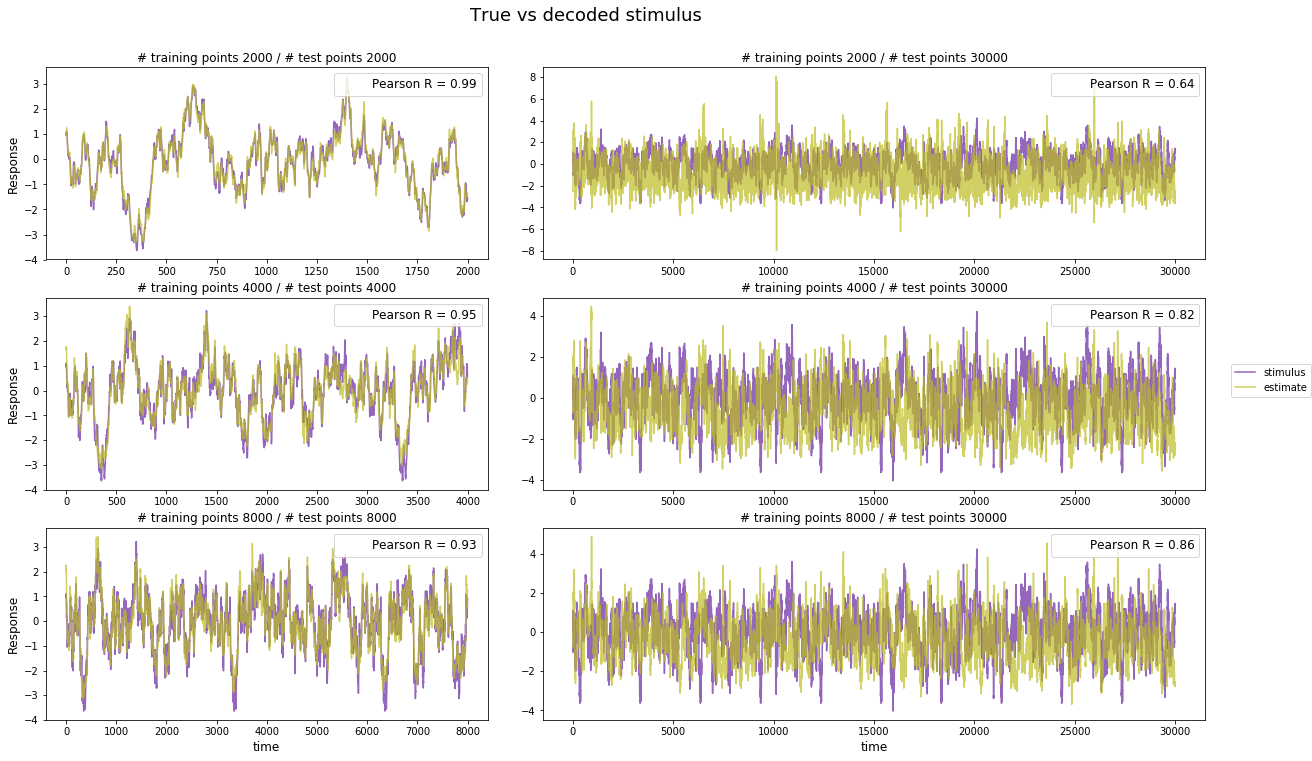

In [210]:
fig, ax = plt.subplots(3, 2, figsize = (20,12), gridspec_kw={'width_ratios': [2,3]})
fig.suptitle('True vs decoded stimulus', fontsize = 18, y = 0.95)
for i in range(3):
    ax[i][0].plot(stim[tau:t_stop[i]+tau], c = 'tab:purple')
    ax[i][0].plot(st_ests[i], alpha = 0.7, c = 'tab:olive')
    ax[i][0].plot([], [], ' ', label="Pearson R = {:.2f}".format(rs[i]))
    
    ax[i][1].plot(stim[tau:t_stop[5]+tau], c = 'tab:purple')
    ax[i][1].plot(cross_est[i][2], alpha = 0.7, c = 'tab:olive')
    ax[i][1].plot([], [], ' ', label="Pearson R = {:.2f}".format(cross_rs[i][2]))
    
    ax[i][0].legend(fontsize = 12, loc = 1)
    ax[i][1].legend(fontsize = 12, loc = 1)
    ax[i][0].set_ylabel('Response', fontsize = 12)
    ax[i][0].set_title('# training points {} / # test points {}'.format(t_stop[i], t_stop[i]), fontsize = 12)
    ax[i][1].set_title('# training points {} / # test points {}'.format(t_stop[i], t_stop[5]), fontsize = 12)

fig.legend(['stimulus','estimate'],fontsize = 10, loc = 'center right', borderaxespad=0.1)    
plt.subplots_adjust(wspace = 0.1, right = 0.93)
ax[2][0].set_xlabel('time', fontsize = 12)
ax[2][1].set_xlabel('time', fontsize = 12)